# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [7]:
import pandas as pd
import numpy as np
from pymystem3 import Mystem
df = pd.read_csv('/datasets/data.csv')
df.info()
df.head()
print('Дубликатов в исходных данных: ',df.duplicated().sum())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB
Дубликатов в исходных данных:  54


**Вывод**

Данные из файла data.csv загружены в dataframe с именем df
Набор данных состоит из 12 колонок и 21525 записей. В колонках days_employed и total_income есть пропущенные значения. которые будут обработаны далее.
Сразу приведем строки к нижнему регистру, для исключения проблем на этапе предобработки данных

In [8]:
for col in ['education','family_status','income_type','purpose']:
    df[col] = df[col].str.lower()

## Шаг 2. Предобработка данных

### Обработка пропусков

Начнем с анализа данных в колонке days_employed, построим гистограмму для понимания распределения значений

821.917808219178

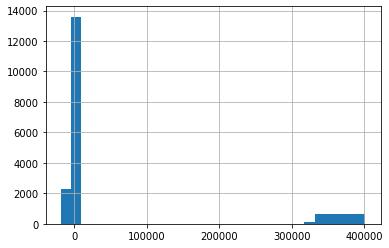

In [9]:
df['days_employed'].hist(bins=30)
300000/365

На гистограмме явно видны аномалии со значениями <0 и больше 300000. С учетом того, что значению 300000 соответствует 821 рабочий год, данные явно некорректные.
Посчитаем общее количество пропущенных и некорректно заполненных значений.

In [10]:
df_days_employed_na = df['days_employed'].isna().sum()
df_days_employed_incor = df[(df['days_employed']<0) | (df['days_employed']>300000)]['days_employed'].count()
print('days_employed количество незаполненных строк -', df_days_employed_na)
print('days_employed количество некорректно заполненных строк -', df_days_employed_incor)
print('days_employed общее количество строк с некорректными или незаполненными значениями -', df_days_employed_na+df_days_employed_incor)

days_employed количество незаполненных строк - 2174
days_employed количество некорректно заполненных строк - 19351
days_employed общее количество строк с некорректными или незаполненными значениями - 21525


Таким образом, в столбце days_employed отсутствуют корректные данные. В данном случае необходимо было бы уточнить у ответственного за подготовку набора, в чем причина (возможно произошел сбой при выгрузке значений из СУБД). Но у нас такой возможности нет. Кроме того, данные из столбца не будут использоваться в дальнейшем при проверке гипотез, поэтому заменим пропущенные данные 0 и не будем делать необоснованных предположений о причинах появления мусорных данных в столбце.

In [11]:
df['days_employed'] = df['days_employed'].fillna(0)
df['days_employed'].isna().sum()

0

Проведем анализ данных в колонке income_type, построим гистограмму для понимания распределения значений

In [12]:
df['total_income'].isna().sum()

2174

У нас 2174 пропущенных значения. Возможно данные по зарплате заемщик не указал целенаправленно, а возможно произошла ошибка при выгрузке данных в датасет.
Удалять строки с пропущенными данными некорректно, т.к. объем таких строк составляет 10% от общей выборки.
Пропущенные данные можно заполнить средней или медианой, осталось определиться по каким группам будем производить заполнение.
Можно предположить что на зарплату может влиять образование, пол и категория заемщика (колонки education, gender, income_type).
Проверим данные предположения. 

In [13]:
display(df.groupby(['education_id','education']).agg({'total_income':['count','min','max','mean','median']}))
display(df.groupby(['gender']).agg({'total_income':['count','min','max','mean','median']}))
display(df.groupby(['income_type']).agg({'total_income':['count','min','max','mean','median']}))
#display(df[df['total_income'].isna()].groupby('education').count())
#display(df[df['total_income'].isna()].groupby('gender').count())
#display(df[df['total_income'].isna()].groupby('income_type').count())

total_income                              \
                                        count           min           max   
education_id education                                                      
0            высшее                      4716  32178.213678  2.265604e+06   
1            среднее                    13693  20667.263793  1.726276e+06   
2            неоконченное высшее          675  34466.133539  9.584346e+05   
3            начальное                    261  25308.586849  4.900673e+05   
4            ученая степень                 6  98752.495442  2.684112e+05   

                                                                
                                           mean         median  
education_id education                                          
0            высшее               207142.515219  175340.818855  
1            среднее              153715.643971  136478.643244  
2            неоконченное высшее  181534.022774  160115.398644  
3            начальное            132155.513626  117137.352825  
4            ученая степень       174750.155792  157259.898555

total_income                                                           
              count            min           max           mean         median
gender                                                                        
F             12752   20667.263793  1.715018e+06  154097.529734  134155.283479
M              6598   21205.280566  2.265604e+06  193169.652274  167714.343716
XNA               1  203905.157261  2.039052e+05  203905.157261  203905.157261

total_income                                              \
                       count            min           max           mean   
income_type                                                                
безработный                2   59956.991984  2.027225e+05  131339.751676   
в декрете                  1   53829.130729  5.382913e+04   53829.130729   
госслужащий             1312   29200.077193  9.104515e+05  170898.309923   
компаньон               4577   28702.812889  2.265604e+06  202417.461462   
пенсионер               3443   20667.263793  7.351033e+05  137127.465690   
предприниматель            1  499163.144947  4.991631e+05  499163.144947   
сотрудник              10014   21367.648356  1.726276e+06  161380.260488   
студент                    1   98201.625314  9.820163e+04   98201.625314   

                                
                        median  
income_type                     
безработный      131339.751676  
в декрете         53829.130729  
госслужащий      150447.935283  
компаньон        172357.950966  
пенсионер        118514.486412  
предприниматель  499163.144947  
сотрудник        142594.396847  
студент           98201.625314

Как мы видим и образование и пол и тип заемщика влияют на размер дохода, поэтому заполним размер дохода по пропущенным значениям медианным значением по группам.
Предварительно удалим одну строку из исходных данных с незаполненным полом заемщика

In [14]:
df = df[df['gender'] != 'XNA']
sorted(df['gender'].unique())

['F', 'M']

In [15]:
data_transformed = df.groupby(['income_type','gender','education_id'])['total_income'].transform('median')
df['total_income'] = df['total_income'].fillna(data_transformed)
df['total_income'].isna().sum()
display(df[df['total_income'].isna()])

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
5936,0,0.0,58,высшее,0,женат / замужем,0,M,предприниматель,0,NaN,покупка жилой недвижимости


Как мы видим - у нас осталась одна строка с незаполненным значением total_income для предпринимателя мужского пола с высшим образованием. заемщиков с такими параметрами в выборке больше нет, поэтому считаю возможным удалить данную строку.

In [16]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21523 entries, 0 to 21524
Data columns (total 12 columns):
children            21523 non-null int64
days_employed       21523 non-null float64
dob_years           21523 non-null int64
education           21523 non-null object
education_id        21523 non-null int64
family_status       21523 non-null object
family_status_id    21523 non-null int64
gender              21523 non-null object
income_type         21523 non-null object
debt                21523 non-null int64
total_income        21523 non-null float64
purpose             21523 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.1+ MB


**Вывод**

Обработаны пропуски в столбцах days_employed, total_income, рассмотрены возможные причины появления появления пропусков и некорректных значений.

### Замена типа данных

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21523 entries, 0 to 21524
Data columns (total 12 columns):
children            21523 non-null int64
days_employed       21523 non-null float64
dob_years           21523 non-null int64
education           21523 non-null object
education_id        21523 non-null int64
family_status       21523 non-null object
family_status_id    21523 non-null int64
gender              21523 non-null object
income_type         21523 non-null object
debt                21523 non-null int64
total_income        21523 non-null float64
purpose             21523 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.1+ MB


Как видно из описания данных, столбцы "days_employed" и "total_income" типа float64. Для столбца "days_employed" возможны только целочисленные значения, а в стобце "total_income" нам не нужны значения после запятой, т.к. размер доходов измеряется десятками/сотнями тысяч рублей, поэтому копейки для анализа несущественны.
Приведем оба столбца к типу int64. Для преобразования типа данных используем метод astype, которая вызовет исключение в случае ошибки преобразования типа (исключение вызовется если, не изменено значение параметра по умолчанию errors='raise')

In [18]:
try:
    df['days_employed'] = df['days_employed'].astype('int64')
    df['total_income'] = df['total_income'].astype('int64')
except:
    print('Ошибка преобразования типов')
    
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21523 entries, 0 to 21524
Data columns (total 12 columns):
children            21523 non-null int64
days_employed       21523 non-null int64
dob_years           21523 non-null int64
education           21523 non-null object
education_id        21523 non-null int64
family_status       21523 non-null object
family_status_id    21523 non-null int64
gender              21523 non-null object
income_type         21523 non-null object
debt                21523 non-null int64
total_income        21523 non-null int64
purpose             21523 non-null object
dtypes: int64(7), object(5)
memory usage: 2.1+ MB


**Вывод**

Преобразованы типы колонок "days_employed" и "total_income" к типу 'int64', ошибок в процессе преобразования типов не возникло.

### Обработка дубликатов

Проверим наличие дубликатов в датасете

In [19]:
df.duplicated().sum()

71

Как мы видим - присутствует 71 дубликат. Поскольку у нас в исходных данных нет уникального идентификатора заемщика, то мы не можем однозначно сказать - дубликат это или это другой заемщик с такими же параметрами по всем столбцам. Для учебного проекта предположим что это дубликат.

In [20]:
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

**Вывод**

Удалены дубликаты в исходных данных, для удаления дубликатов использован метод drop_duplicates() с последующим перестроением индекса reset_index(drop=True)

### Лемматизация

Проанализируем цели получения кредита

In [21]:
df['purpose'].value_counts()

свадьба                                   791
на проведение свадьбы                     768
сыграть свадьбу                           765
операции с недвижимостью                  675
покупка коммерческой недвижимости         661
операции с жильем                         652
покупка жилья для сдачи                   651
операции с коммерческой недвижимостью     650
покупка жилья                             646
жилье                                     646
покупка жилья для семьи                   638
строительство собственной недвижимости    635
недвижимость                              633
операции со своей недвижимостью           627
строительство жилой недвижимости          624
покупка недвижимости                      620
покупка своего жилья                      620
строительство недвижимости                619
ремонт жилью                              607
покупка жилой недвижимости                605
на покупку своего автомобиля              505
заняться высшим образованием      

Проанализировав данные - можно выделить 6 основный категорий, которые в дальнейшем используем для построения справочника.
1) свадьба
2) недвижимость
3) ремонт
4) автомобиль
5) образование
6) другое (если не получится отнести цель кредита ни к одной из выделенныъ выше категорий)

Для лемматизации целей кредита (приведения всех слов к словарной форме) будем использовать библиотеку pymysystem3. Оформим определение категории цели кредита в виде отдельной функции, которая в качестве параметра принимает цель кредита, а возвращает имя категории цели кредита. Проведем категоризацию цели кредита, заполним получившееся значение в столбец 'purpose_group'

In [22]:
m = Mystem()
def purpose_group(purpose):
    lemmas = m.lemmatize(purpose)
    if 'свадьба' in lemmas:
        return 'свадьба'
    elif 'ремонт' in lemmas:
        return 'ремонт'
    elif ('недвижимость' in lemmas) or ('жилье' in lemmas):
        return 'недвижимость'
    elif 'автомобиль' in lemmas:
        return 'автомобиль'
    elif 'образование' in lemmas:
        return 'образование'
    else:
        return 'другое'

df['purpose_group'] = df['purpose'].apply(purpose_group)
df['purpose_group'].value_counts()


недвижимость    10202
автомобиль       4306
образование      4013
свадьба          2324
ремонт            607
Name: purpose_group, dtype: int64

**Вывод**

Проведена лемматизация целей получения кредита, выделены основные категории и занесены в отдельный столбец 'purpose_group'

### Категоризация данных

Часто объекты, имеющие определённое значение признака, присутствуют в наборе только единожды. Работать с такими отрывками и делать из них статистические выводы нельзя. Поэтому, с такими данными проводится категоризация - объединение данных в категории.
Категоризация цели кредита была проведена в пункте 2.4.
Для дальнейшего анализа в разделе 3 нам потребуется категоризировать 'Наличие детей', 'Семейное положение' и 'Уровень дохода'. 

Рассмотрим семейное положение.

In [23]:
df['family_status'].value_counts()

женат / замужем          12338
гражданский брак          4150
не женат / не замужем     2810
в разводе                 1195
вдовец / вдова             959
Name: family_status, dtype: int64

Ранее мы привели данную колонку к нижнему регистру, поэтому сейчас у нас получается 5 категорий семейного положения, дополнительных действий не требуется.

Перейдем к колонке 'Наличие детей'

In [24]:
df['children'].value_counts()

 0     14089
 1      4808
 2      2052
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Как мы можем видеть - в списке есть некорректные значения: -1 и 20. 
Выделим по данной колонке следующие категории:
1) Нет детей
2) Один ребенок
3) Два ребенка
4) Многодетная семья (3 и более детей)
5) Неизвестно (<0, >19)

In [25]:
def children_group(children):
    if children == 0:
        return 'нет детей'
    elif children == 1:
        return 'один ребенок'
    elif children == 2:
        return 'два ребенка'
    elif (children >= 3) and (children < 20):
        return 'многодетная семья'
    else:
        return 'неизвестно'

df['children_group'] = df['children'].apply(children_group)
df['children_group'].value_counts()

нет детей            14089
один ребенок          4808
два ребенка           2052
многодетная семья      380
неизвестно             123
Name: children_group, dtype: int64

Рассмотрим категоризацию 'total_income'. Обычно для дохода выделяют 3 категории низкий, средний, высокий. 
Для определения границ дохода для отнесения к одной из категорий рассмотрим перцентили 25 и 75 по столбцу total_income. 

In [26]:
cut_points = [np.percentile(df['total_income'], i) for i in [25, 75]]
print(cut_points)


[107499.0, 196883.0]


Таким образом, немного округлив значения, можно считать низким доход менее 100 тысяч рублей, высоким более 200.

In [27]:
def total_income_group(total_income):
    if (total_income >= 0) and (total_income<100000):
        return 'низкий доход'
    elif (total_income >= 100000) and (total_income<200000):
        return 'средний доход'
    elif (total_income >= 200000):
        return 'высокий доход'
    else:
        return 'доход неизвестен'

df['total_income_group'] = df['total_income'].apply(total_income_group)
df['total_income_group'].value_counts()

средний доход    11845
высокий доход     5142
низкий доход      4465
Name: total_income_group, dtype: int64

**Вывод**

Проведена категоризация данных по колонкам "Цель кредита", "Наличие детей", "Уровень дохода", "Семейное положение".  

## Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

Сформируем сводную таблицу по категориям наличия детей. Далее сформируем процент наличия задолженности по каждой группе.

In [28]:
pivot_table_children = df.pivot_table(index = 'children_group', columns = 'debt', values = 'total_income', aggfunc = 'count')
pivot_table_children['debt_percent'] = 100*pivot_table_children[1]/(pivot_table_children[0]+pivot_table_children[1])
pivot_table_children.sort_values(by='debt_percent', ascending=False)

debt,0,1,debt_percent
children_group,,,
два ребенка,1858,194,9.454191
один ребенок,4364,444,9.234609
многодетная семья,349,31,8.157895
нет детей,13026,1063,7.544893
неизвестно,114,9,7.317073


**Вывод**

Как видно из сводной таблицы:
1) Наибольший процент задолженности у семей с одним или двумя детьми.

2) Немного меньше процент задолженности у многодетных семей.

3) Наименьший процент задолженности у семей без детей, семьи с неизвестным статусом имеют примерно такой же процент задолженности, поэтому можно предположить что речь также идет о семьях без детей.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [29]:
pivot_table_family_status = df.pivot_table(index = 'family_status', columns = 'debt', values = 'total_income', aggfunc = 'count')
pivot_table_family_status['debt_percent'] = 100*pivot_table_family_status[1]/(pivot_table_family_status[0]+pivot_table_family_status[1])
pivot_table_family_status.sort_values(by='debt_percent', ascending=False)

debt,0,1,debt_percent
family_status,,,
не женат / не замужем,2536,274,9.750890
гражданский брак,3762,388,9.349398
женат / замужем,11407,931,7.545793
в разводе,1110,85,7.112971
вдовец / вдова,896,63,6.569343


**Вывод**

Как видно из сводной таблицы:
1) Наибольший процент задолженности у незамужних/неженатых заемщиков и у заемщиков, состоящих в гражданском браке.

2) Наименьший процент у заемщиков категории вдовец/вдова

3) Среднее значение у заемщиков категорий женат/замужем и в разводе

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [30]:
pivot_table_total_income = df.pivot_table(index = 'total_income_group', columns = 'debt', values = 'total_income', aggfunc = 'count')
pivot_table_total_income['debt_percent'] = 100*pivot_table_total_income[1]/(pivot_table_total_income[0]+pivot_table_total_income[1])
pivot_table_total_income.sort_values(by='debt_percent', ascending=False)

debt,0,1,debt_percent
total_income_group,,,
средний доход,10819,1026,8.661883
низкий доход,4111,354,7.928331
высокий доход,4781,361,7.020615


**Вывод**

Как видно из сводной таблицы:
1) Наименьший процент задолженности наблюдается у группы заемщиков с высоким доходом, это можно объяснить тем, что с высоким доходом легче платить ежемесячные платежи по кредиты.

2) Примерно на процент выше доля должников у группы заемщиков с низким доходом, но самый высокий процент задолженности у группы заемщиков со средним доходом. Это можно объяснить тем, что заемщики с низким доходом вынуждены планировать бюджет и поэтому при взятии кредита лучше представляют как его отдавать. А должники из группы со средним доходом не всегда планируют бюджет и поэтому могут просрочить оплату по кредиту.

3) В целом по данному пукнту разброс не очень большой - в пределах 2%. Для анализа было бы полезно знать сумму кредита и сопоставить ее с доходом заемщика, без суммы кредита картина получается неполной.

- Как разные цели кредита влияют на его возврат в срок?

In [31]:
pivot_table_purpose = df.pivot_table(index = 'purpose_group', columns = 'debt', values = 'total_income', aggfunc = 'count')
pivot_table_purpose['debt_percent'] = 100*pivot_table_purpose[1]/(pivot_table_purpose[0]+pivot_table_purpose[1])
pivot_table_purpose.sort_values(by='debt_percent', ascending=False)

debt,0,1,debt_percent
purpose_group,,,
автомобиль,3903,403,9.359034
образование,3643,370,9.220035
свадьба,2138,186,8.003442
недвижимость,9455,747,7.322094
ремонт,572,35,5.766063


**Вывод**

Как видно из сводной таблицы:

1) Наименьший процент задолженности наблюдается по кредитам на ремонт, возможно это связано с тем, что суммы кредита меньше, чем на другие цели. Но поскольку, суммма кредита неизвестна, данное предположение необосновано.

2) Наибольший процент задолженности по кредитам на автомобили и образование.

3) Задолженность по кредитам на свадьбу возникает примерно у 8% заемщиков.

## Шаг 4. Общий вывод

В ходе проведения исследовани были проанализированы входные данные - статистика о платёжеспособности клиентов.
Набор данных состоит из 12 колонок и 21525 записей. 
Обработаны пропуски в столбцах days_employed, total_income, рассмотрены возможные причины появления появления пропусков и некорректных значений.
Проведена лемматизация целей кредита.
Для дальнейшего анализа в проведена категоризация по колонкам 'Наличие детей', 'Уровень дохода', 'Цель кредита'.
Далее с помощью сводных таблиц получены ответы на вопросы Заказчика:
•	Есть ли зависимость между наличием детей и возвратом кредита в срок?
•	Есть ли зависимость между семейным положением и возвратом кредита в срок?
•	Есть ли зависимость между уровнем дохода и возвратом кредита в срок?
•	Как разные цели кредита влияют на его возврат в срок?
По каждому из вопросов зависимость есть, но разброс процентов должников по категориям не столь существенный и составляет не более 4%. В целом процент задолженности по каждой из категорий не превышает 9.8%

Рекомендую обратить особое внимание на следующие группы заемщиков:

1) Заимщики с наименьшим процентов задолженности
- многодетные семьи
- вдовцы/вдовы
- с высоким доходом
- с целью кредита на ремонт

2) Заемщики с наибольшим процентом задолженности
- семьи с одним или двумя детьми
- незамежние/неженатые, в гражданском браке
- со средним доходом
- с целью кредита на автомобиль или образование

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл;
- [x]  файл изучен;
- [x]  определены пропущенные значения;
- [x]  заполнены пропущенные значения;
- [x]  есть пояснение, какие пропущенные значения обнаружены;
- [x]  описаны возможные причины появления пропусков в данных;
- [x]  объяснено, по какому принципу заполнены пропуски;
- [x]  заменен вещественный тип данных на целочисленный;
- [x]  есть пояснение, какой метод используется для изменения типа данных и почему;
- [x]  удалены дубликаты;
- [x]  есть пояснение, какой метод используется для поиска и удаления дубликатов;
- [x]  описаны возможные причины появления дубликатов в данных;
- [x]  выделены леммы в значениях столбца с целями получения кредита;
- [x]  описан процесс лемматизации;
- [x]  данные категоризированы;
- [x]  есть объяснение принципа категоризации данных;
- [x]  есть ответ на вопрос: "Есть ли зависимость между наличием детей и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Есть ли зависимость между семейным положением и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Есть ли зависимость между уровнем дохода и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Как разные цели кредита влияют на его возврат в срок?";
- [x]  в каждом этапе есть выводы;
- [x]  есть общий вывод.